In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

from openai import OpenAI

API_KEY = "sk-vfhvxxmmeguamhsrdesqwtzlpknqoqdtzzphmyrrpdcyxpdl"
client = OpenAI(api_key=API_KEY, base_url="https://api.siliconflow.cn/v1")


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 

# Convert to numpy arrays
X_numpy = X.values.astype(np.float32)
y_numpy = y.values.flatten().astype(np.int64)

# Normalize features
X_numpy = (X_numpy - X_numpy.min()) / (X_numpy.max() - X_numpy.min())
# Reshape data to include channel dimension for CNN (batch_size, channels, height, width)
X_numpy = X_numpy.reshape(-1, 1, 8, 8)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42)

# metadata 
print(optical_recognition_of_handwritten_digits.metadata) 
  
# variable information 
print(optical_recognition_of_handwritten_digits.variables) 


{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'ID': 280, 'type': 'NATIVE', 'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'venue': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, 

In [3]:
def classify_digits_with_llm(X_data, y_data, n_samples=100, examples_per_prompt=10):
    """
    Classify handwritten digits from the UCI dataset using an LLM.
    
    Args:
        X_data: Feature data with shape (n_samples, 1, 8, 8) - already preprocessed UCI data
        y_data: Label data with shape (n_samples,)
        n_samples: Number of test samples to classify
        examples_per_prompt: Number of examples to include in each prompt
    
    Returns:
        Accuracy of the LLM's predictions
    """
    # Ensure we don't try to use more samples than available
    n_samples = min(n_samples, len(X_data))
    
    # Select random indices for testing
    test_indices = random.sample(range(len(X_data)), n_samples)
    
    predictions = []
    ground_truth = []
    
    # Process each test sample
    for i, idx in enumerate(test_indices):
        print(f"Processing sample {i+1}/{n_samples}")
        
        # Get the test image and label
        test_image = X_data[idx]
        test_label = y_data[idx]
        
        # Select random examples for few-shot learning (excluding the current test sample)
        available_indices = [j for j in range(len(X_data)) if j != idx]
        example_indices = random.sample(available_indices, examples_per_prompt)
        
        prompt = "I'll show you examples of 8x8 pixel representations of handwritten digits. Each example is shown as an ASCII art where darker pixels represent higher intensity.\n\n"
        
        # Add examples
        for ex_idx in example_indices:
            example_img = X_data[ex_idx]
            example_lbl = y_data[ex_idx]
            
            # Convert to ASCII art
            ascii_art = ""
            for row in example_img.squeeze():
                line = ""
                for pixel in row:
                    if pixel > 0.75:
                        line += "██"
                    elif pixel > 0.5:
                        line += "▓▓"
                    elif pixel > 0.25:
                        line += "▒▒"
                    elif pixel > 0.0:
                        line += "░░"
                    else:
                        line += "  "
                ascii_art += line + "\n"
            
            prompt += f"Example:\n{ascii_art}Digit: {example_lbl}\n\n"
        
        # Add the test sample
        ascii_art = ""
        for row in test_image.squeeze():
            line = ""
            for pixel in row:
                if pixel > 0.75:
                    line += "██"
                elif pixel > 0.5:
                    line += "▓▓"
                elif pixel > 0.25:
                    line += "▒▒"
                elif pixel > 0.0:
                    line += "░░"
                else:
                    line += "  "
            ascii_art += line + "\n"

        prompt += f"Now, predict the digit shown in the following input:\n{ascii_art}\nProvide only the digit (0-9) as your output answer."
        print("Digit to be identified:")
        print(ascii_art)
        # Query the LLM with retries
        max_retries = 5
        for attempt in range(max_retries):
            try:
                completion = client.chat.completions.create(
                    model='Qwen/Qwen2.5-VL-72B-Instruct',  # Adjust model as needed
                    messages=[{'role': 'user', 'content': prompt}],
                    temperature=0
                )
                response = completion.choices[0].message.content
                
                # Extract just the digit from the response
                digit = int(''.join(filter(str.isdigit, response[:10])))
                predictions.append(digit)
                ground_truth.append(test_label)
                
                print(f"Sample {i+1}: Predicted {digit}, Actual {test_label}")
                break
                
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                if attempt == max_retries - 1:
                    # If all retries fail, use a random prediction
                    rand_digit = random.randint(0, 9)
                    predictions.append(rand_digit)
                    ground_truth.append(test_label)
                    print(f"Sample {i+1}: Failed, using random {rand_digit}, Actual {test_label}")
        if i < n_samples - 1:  # Don't delay after the last sample
            time.sleep(5)       # 5s delay after every prompt to stay under token-per-minute limit/not overload server

    return predictions, ground_truth

In [4]:
predictions, ground_truth = classify_digits_with_llm(X_numpy, y_numpy)
print('Accuracy:', str(accuracy_score(ground_truth, predictions)))

Processing sample 1/100
Digit to be identified:
    ░░▓▓▓▓▓▓▓▓  
    ░░▓▓▒▒██▓▓  
        ░░██░░  
    ░░▓▓████░░  
    ████████▒▒  
    ░░██▓▓      
    ░░██░░      
    ▒▒▓▓        

Sample 1: Predicted 8, Actual 7
Processing sample 2/100
Digit to be identified:
    ▒▒██▓▓░░    
  ░░██▒▒▓▓██    
  ▒▒▓▓    ▓▓▒▒  
  ▒▒██░░  ▒▒▒▒  
  ▒▒▓▓░░  ░░▒▒  
  ░░▓▓    ▓▓▒▒  
  ░░██▒▒▒▒██░░  
    ▒▒████░░    

Sample 2: Predicted 8, Actual 0
Processing sample 3/100
Digit to be identified:
    ░░▓▓██░░    
    ▓▓██▒▒      
    ██░░        
  ░░██          
  ░░██████▓▓    
  ▒▒██▒▒▒▒██▓▓  
    ██▓▓▒▒██▒▒  
    ░░████▒▒    

Sample 3: Predicted 6, Actual 6
Processing sample 4/100
Digit to be identified:
      ░░██▓▓    
      ▒▒██▓▓    
      ▓▓██▒▒    
  ░░▒▒████░░    
  ▒▒██████      
    ░░████      
      ████░░    
        ▓▓██▒▒  

Sample 4: Predicted 1, Actual 1
Processing sample 5/100
Digit to be identified:
    ░░▓▓░░      
    ████        
  ░░██░░        
  ▒▒██          
  ▒▒▓▓▒▒▓▓▒▒░░  

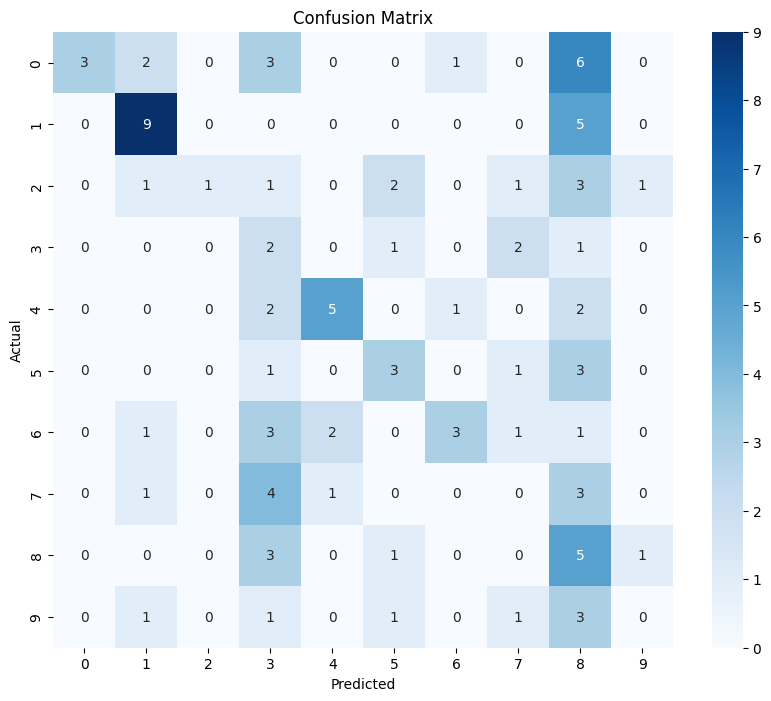

In [5]:
cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()